<img src="https://developers.refinitiv.com/sites/all/themes/custom/trpdc_schwinn/imgs/logo/refinitiv_header_logo.svg" width="50%" align="left" style="vertical-align: top; padding-top: 23px;">

**Overview** 

This article will cover the Equity Pair trading use case and go from a single pair example to an industrialised search process with commonly used statistical tests, combinatoric generators and computed in a brute force fashion using vectorization and parallelization where appropriate. Finally, we will use some filtering and visualization tools to eyeball the results and suggest potential next steps.

**Sections**

[Introduction to Pair Trading](#Introduction)

[Single Pair Example](#Single)

[Introducing More Statistical Rigour](#Rigour)

[Industrializing Our Search Process](#Industrialise)

[Calculation Details - Vectorization or Parallisation](#Calculation)

[Filtering our Universe Down](#Filtering)

[Final Visual Check - Seaborn FacetGrid](#Visualize)

[Conclusion](#Conclusion)

**Pre-requisites:**

**Thomson Reuters Eikon / Refinitiv Workspace** with access to [Eikon Data APIs](https://refini.tv/3bvPev5) (Free Trial Available)

Python 2.x/3.x

Required Python Packages: [eikon](https://pypi.org/project/eikon/), [pandas](https://pypi.org/project/pandas/), [numpy](https://pypi.org/project/numpy/), [matplotlib](https://pypi.org/project/matplotlib/), [statsmodels](https://pypi.org/project/statsmodels/), [swifter](https://pypi.org/project/swifter/), [seaborn](https://pypi.org/project/seaborn/)

<a id='Introduction'></a>
### Introduction to Pair Trading

Pair trading is a time-honoured market-neutral type of statistical arbitrage trading strategy. It is market-neutral because once you have identified a suitable pair (two stocks for example) - you would be long one stock and short the other. This means that whatever the broader market does ie goes up or down - you are theoretically somewhat insulated. Another interesting characteristic of this strategy is its low capital outlay as the short side of the trade funds the long side of the trade - so this type of approach is very efficient from a capital as well as a risk point of view.

So how can we find these pairs? Well there are many approaches - some concentrate on finding companies in similar sectors or business areas or geographies or markets. Some focus on identifying groups of fundamental criteria. 

Lets start by taking two well-known automakers - say Tesla and General Motors in the United States and see what we can find out about the price movement of these. 

<a id='Single'></a>
### Single Pair Example

First lets import some of the packages we will be using.

In [1]:
%matplotlib inline
import eikon as ek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import adfuller
import itertools
import swifter
import seaborn as sns

ek.set_app_key('Your API KEY here')

/Users/jasonram/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


First, lets load some timeseries data for both stocks using the ek.get_timeseries function.

In [2]:
rics = ['TSLA.O','GM']
s = '2010-01-06'
e = '2019-12-08'
i = 'daily'
df = ek.get_timeseries(rics,  # RICs
              fields=['CLOSE'],  # fields to be retrieved
              start_date=s,  # start time
              end_date=e,  # end time
              interval=i)
df

CLOSE,TSLA.O,GM
Date,,
2013-12-23,143.55,41.29
2013-12-24,151.41,40.88
2013-12-26,155.50,41.52
2013-12-27,151.12,40.94
2013-12-30,152.44,40.69
...,...,...
2019-12-02,334.87,35.88
2019-12-03,336.20,35.53
2019-12-04,333.03,35.80


Next we want to get rid of any non-complete (ie N/A) rows as thiis will not play well with some our routines downstream.

In [3]:
df.dropna(inplace=True)
df

CLOSE,TSLA.O,GM
Date,,
2013-12-23,143.55,41.29
2013-12-24,151.41,40.88
2013-12-26,155.50,41.52
2013-12-27,151.12,40.94
2013-12-30,152.44,40.69
...,...,...
2019-12-02,334.87,35.88
2019-12-03,336.20,35.53
2019-12-04,333.03,35.80


Lets add both Spread and Ratio columns as we will want to chart these - particularly the Ratio - as this is the series we will be hoping to trade on and we also print a Pearson Correlation Coefficient.

In [4]:
df['Spread'] = df['TSLA.O'] - df['GM']
df['Ratio'] = df['TSLA.O'] / df['GM']
mean = df['Ratio'].mean()
corr = df['TSLA.O'].corr(df['GM'])
print(corr)
df

0.44026737012835354


CLOSE,TSLA.O,GM,Spread,Ratio
Date,,,,
2013-12-23,143.55,41.29,102.26,3.476629
2013-12-24,151.41,40.88,110.53,3.703767
2013-12-26,155.50,41.52,113.98,3.745183
2013-12-27,151.12,40.94,110.18,3.691255
2013-12-30,152.44,40.69,111.75,3.746375
...,...,...,...,...
2019-12-02,334.87,35.88,298.99,9.333055
2019-12-03,336.20,35.53,300.67,9.462426
2019-12-04,333.03,35.80,297.23,9.302514


The code below charts our ratio between TSLA.O and GM. We add a mean value of the ratio - this is the mean to which we hope the ratio will revert to. Adding a mean and standard deviation thresholds onto the chart can give us interesting entry and exit signals over time. 

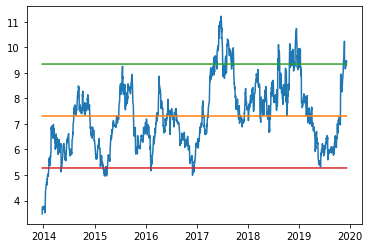

In [5]:
fig = plt.figure()
ax = plt.axes()

x = df.index.values
plt.plot(x, df['Ratio'], label='Ratio')
plt.plot(x, (df['Ratio'].values.mean().repeat(len(x))), label='Mean')
stdplus = df['Ratio'].values.mean() + (1.5*df['Ratio'].values.std())
stdminus = df['Ratio'].values.mean() - (1.5*df['Ratio'].values.std())
#plt.plot(x, (df['Ratio'].values.mean().repeat(len(x))), label='SD1')
plt.plot(x, (stdplus.repeat(len(x))), label='SD+1.5')
plt.plot(x, (stdminus.repeat(len(x))), label='SD-1.5');


From the above chart we can see that adding the mean and standard deviation thresholds onto the chart might give us interesting entry and exit signals over time. The lower bound of 1.5 times standard deviation seems to be a pretty reliable entry point for this pair - and has been tested on 5 occasions over the last decade - all with minimal drawdown and large reversion to mean in each case. 

The upper bound of 1.5 times standard deviation seems to be a reasonable threshold till 2017 - but since then it has been breached on a number of occasions - so we may wish to expand the upper bound to 2 standard deviations or more. 

Whilst interesting - this approach suffers from 2 drawbacks - firstly, its still a bit imprecise and secondly it relies on me knowing what the appropriate pair should be. Lets deal with the first of these drawbacks.

<a id='Rigour'></a>
### Introduce More Statistical Rigour 

Lets consider some more rigorous statistical tests.

For this particular strategy we want to see a relatively high level of correlation between the two stock price series. Correlation is a measure of directional relatedness - ie if GM rises does Tesla rise. The range of correlation is from -1 to +1. Correlation in non-stationary timeseries may just be reflecting autoregression (AR processes) - so we need conduct some additional tests.

It is important that the ratio series is mean reverting. It is this property that we wish to identify & exploit. To help us in this task we can test for stationarity of the series. We will use the Augmented Dickey Fuller (ADF) test to see if we can reject the null hypothesis that the Ratio timeseries has a unit root (ie the series is non-stationary).  

Another statistical property we wish to be present is that the two stocks should be cointegrated. This is the co-movement of both time series (which could be non-stationary). We will use the Engle-Granger two-step cointegration test to see if we can reject the null hypothesis that the pair are NOT cointegrated. This is important as both stocks in the pair should display some quality of cointegratedness for this type of strategy to be exploitable. Thankfully the excellent statsmodels package provides this functionality for us. 

In [6]:
print(adfuller(df['Ratio'])[0:5])

(-3.5915050452251878, 0.005925525329472267, 0, 1499, {'1%': -3.4347199356122493, '5%': -2.86347004827819, '10%': -2.567797534300163})


In [7]:
result = ts.coint(df['TSLA.O'], df['GM'])
print(result)

(-3.698009073896884, 0.018433668450995002, array([-3.90376106, -3.34020915, -3.04728056]))


From the ADF output we can see that the critical value is -3.59 with a p-value of 0.005. The critical value is less than the t-values at the 1%,5% & 10% confidence levels and the p-value is less than 0.05 (95% confidence level). So we can reject the null hypothesis. 

From the cointegration output we can see that the critical value is -3.69 with a p-value of 0.018. The critical value is less than the t-values at the 5% & 10% confidence levels, but not at the 1% level and the p-value of 0.018 is less than 0.05 (95% confidence interval). So we can reject the null hypothesis.

<a id='Industrialise'></a>
### Industrialising Our Search Process

So we have seen how it works for one pair - lets try and deal with the second drawback and try to industrialise this search for potential pairs to a whole universe of stocks - say the FTSE 100 index - but it could of course be any universe or list of instruments. So lets get a list of constituents for our chosen index using the ek.get_data function. The get_data function can be passed a chain RIC or a list of RICs - here we pass a chain RIC for the FTSE 100. 

In [8]:
rics, err = ek.get_data('0#.FTSE','CF_Name')
rics

,Instrument,CF_NAME
0,STAN.L,STANDRD CHART BK
1,CRDA.L,CRODA INTL
2,ANTO.L,ANTOFAGASTA
3,MRW.L,MORRISON SUPMKT
4,EZJ.L,EASYJET
...,...,...
96,ULVR.L,UNILEVER
97,OCDO.L,OCADOL
98,LSE.L,LOND STOCK EXCH
99,TSCO.L,TESCO


Here we take our list of RIC codes for FTSE 100 index and then we add a start and end date parameter, select the daily interval and the 'CLOSE' field and get the underlying time series for each RIC in the list of instruments.  We then build a larger dataframe by concatenating each Price series to the base dataframe, whilst renaming the column to the relevant RIC. 

In [9]:
instruments = rics['Instrument'].astype(str).values.tolist()

s = '2010-01-06'
e = '2019-12-08'
inv = 'daily'

data1 = pd.DataFrame()

for i in instruments:
    
    df1 = ek.get_timeseries(i,  # RICs
              fields=['CLOSE'],  # fields to be retrieved
              start_date=s,  # start time
              end_date=e,  # end time
              interval=inv)
    df1.rename(columns = {'CLOSE': i}, inplace = True)
    if len(data1):
        data1 = pd.concat([data1, df1], axis=1)
    else:
        data1 = df1

So lets have a look at our larger base dataframe.

In [10]:
data1

,STAN.L,CRDA.L,ANTO.L,MRW.L,EZJ.L,BNZL.L,SGE.L,SVT.L,MGGT.L,BLND.L,...,RDSa.L,FERG.L,ICP.L,BAES.L,DCC.L,ULVR.L,OCDO.L,LSE.L,TSCO.L,LGEN.L
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-06,1485.034145,843.591603,1038.0,269.360555,356.172569,660.0,226.058168,1083.0,278.9,457.9,...,1930.5,1435.864625,294.342982,371.4,1783.713916,1955.0,NaN,660.001109,412.05,80.10
2010-01-07,1471.279583,854.853142,1023.0,275.012838,347.547586,663.0,229.659094,1072.0,276.5,458.7,...,1926.5,1487.559972,296.953118,371.5,1809.564843,1931.0,NaN,666.449131,412.00,81.80
2010-01-08,1489.160513,854.341254,1024.0,277.546621,347.253553,663.5,229.959171,1084.0,280.5,461.4,...,1910.0,1517.100170,297.153897,368.5,1822.490306,1936.0,NaN,651.710795,415.95,84.30
2010-01-11,1457.983507,855.365030,1020.0,282.809092,342.843050,674.0,230.059197,1091.0,278.3,473.4,...,1927.0,1504.440085,296.149999,367.4,1809.564843,1930.0,NaN,656.777098,417.85,82.55
2010-01-12,1421.304677,839.496499,1001.0,285.927593,342.254983,658.5,229.959171,1089.0,269.9,473.6,...,1896.0,1526.595234,292.937524,366.3,1792.330892,1929.0,NaN,641.117616,421.00,82.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-02,694.200000,4964.000000,869.6,199.350000,1325.000000,2120.0,736.400000,2200.0,628.4,566.4,...,2215.5,6658.000000,1542.000000,561.2,6562.000000,4542.0,1227.0,6750.000000,231.50,275.80
2019-12-03,677.200000,4894.000000,845.2,195.550000,1306.500000,2056.0,732.000000,2211.0,618.8,571.6,...,2161.0,6474.000000,1533.000000,548.4,6486.000000,4524.5,1194.0,6682.000000,226.30,270.70
2019-12-04,679.000000,4874.000000,866.6,192.800000,1373.500000,2071.0,722.200000,2236.0,640.2,585.6,...,2164.0,6636.000000,1553.000000,552.6,6474.000000,4520.5,1228.0,6794.000000,226.10,277.20


We need to check our dataframe to see if the are any NAN values present as this will not play well with the statsmodels package we wish to use downstream.

In [11]:
data2=data1.copy()

Drop any rows that are entirely blank - I noticed a few of these being returned

In [12]:
data2.dropna(how='all', inplace=True)

Drop columns which have a nan in them

In [13]:
nalist = data2.columns[data2.isna().any()].tolist()
nalist

['ICAG.L',
 'EVRE.L',
 'MNG.L',
 'AUTOA.L',
 'JETJ.L',
 'CCH.L',
 'POLYP.L',
 'GLEN.L',
 'AVV.L',
 'OCDO.L']

In [14]:
data2.drop(nalist, axis=1, inplace=True)
data2

,STAN.L,CRDA.L,ANTO.L,MRW.L,EZJ.L,BNZL.L,SGE.L,SVT.L,MGGT.L,BLND.L,...,BARC.L,RDSa.L,FERG.L,ICP.L,BAES.L,DCC.L,ULVR.L,LSE.L,TSCO.L,LGEN.L
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-06,1485.034145,843.591603,1038.0,269.360555,356.172569,660.0,226.058168,1083.0,278.9,457.9,...,283.590022,1930.5,1435.864625,294.342982,371.4,1783.713916,1955.0,660.001109,412.05,80.10
2010-01-07,1471.279583,854.853142,1023.0,275.012838,347.547586,663.0,229.659094,1072.0,276.5,458.7,...,291.441863,1926.5,1487.559972,296.953118,371.5,1809.564843,1931.0,666.449131,412.00,81.80
2010-01-08,1489.160513,854.341254,1024.0,277.546621,347.253553,663.5,229.959171,1084.0,280.5,461.4,...,296.106780,1910.0,1517.100170,297.153897,368.5,1822.490306,1936.0,651.710795,415.95,84.30
2010-01-11,1457.983507,855.365030,1020.0,282.809092,342.843050,674.0,230.059197,1091.0,278.3,473.4,...,292.827482,1927.0,1504.440085,296.149999,367.4,1809.564843,1930.0,656.777098,417.85,82.55
2010-01-12,1421.304677,839.496499,1001.0,285.927593,342.254983,658.5,229.959171,1089.0,269.9,473.6,...,292.457984,1896.0,1526.595234,292.937524,366.3,1792.330892,1929.0,641.117616,421.00,82.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-02,694.200000,4964.000000,869.6,199.350000,1325.000000,2120.0,736.400000,2200.0,628.4,566.4,...,169.180000,2215.5,6658.000000,1542.000000,561.2,6562.000000,4542.0,6750.000000,231.50,275.80
2019-12-03,677.200000,4894.000000,845.2,195.550000,1306.500000,2056.0,732.000000,2211.0,618.8,571.6,...,166.340000,2161.0,6474.000000,1533.000000,548.4,6486.000000,4524.5,6682.000000,226.30,270.70
2019-12-04,679.000000,4874.000000,866.6,192.800000,1373.500000,2071.0,722.200000,2236.0,640.2,585.6,...,167.160000,2164.0,6636.000000,1553.000000,552.6,6474.000000,4520.5,6794.000000,226.10,277.20


<a id='Calculate'></a>
### Calculation details - Vectorization or Parallelization - decisions, decisions? Who cares with swifter!

We now wish to derive a list of all combinations of RICs - we can do this using the excellent itertools.combinations combinatoric generator function - with no repeated elements. 

Then for each of the RIC pairs/ratios in this list we want to calculate and store the output from the ADF test, Engle-Granger cointegration test and Pearsons correlation coefficient. As this is a somewhat brute force approach I tried to follow some of the performance advice I had seen - and finally opted for the syntactically compact apply method using a lambda function. This is supposed to be more efficient than simple looping, iterrows or itertuples. 

Still not satisfied - I searched for some parallelisation or speedup potential and ran across the **Switfer** package. It seemed to offer a great deal - supercharging any vanilla df.apply function by either: 

"**a) trying to vectorize the function where possible or, where vectorization is not possible:**

**b) automatically decide on the basis of speed whether to use Dask Parallel Processing or the vanilla Pandas apply**"

Well I must say - what fantastic promise - and just one package to import and a single modifier to add - instead of df.apply I use df.swifter.apply. What is even better is we have a progress bar while we wait - super awesome. *I really <3 python sometimes.* I trust you are digging the slackness here :)

After some power has been consumed and heat generated - we hopefully end up with some light in the shape of complete combinatoric calculations for over 4000 pairs.

In [15]:
all_pairs = list(itertools.combinations(data2.columns,2)) #combinatoric generator no repeated elements, no reverses
coint_df = pd.DataFrame(all_pairs,columns =['RIC1','RIC2']) 
coint_df['ADF'] = coint_df.swifter.apply(lambda row: adfuller((data2[row.RIC1]/data2[row.RIC2])), axis=1)
coint_df['EG'] = coint_df.swifter.apply(lambda row: ts.coint(data2[row.RIC1], data2[row.RIC2]), axis=1)
coint_df['PCorr'] = coint_df.swifter.apply(lambda row: np.corrcoef(data2[row.RIC1],data2[row.RIC2]), axis =1)

coint_df

,RIC1,RIC2,ADF,EG,PCorr
0,STAN.L,CRDA.L,"(-4.120545230989658, 0.0008955008162009861, 27...","(-2.284507588332593, 0.3813083067119164, [-3.9...","[[1.0, -0.7856641647648388], [-0.7856641647648..."
1,STAN.L,ANTO.L,"(-1.9417367947019848, 0.3126885609387773, 11, ...","(-1.7499873027039807, 0.653681587381541, [-3.9...","[[1.0, 0.7103743817628201], [0.710374381762820..."
2,STAN.L,MRW.L,"(-1.5636739383817009, 0.5018110522175807, 2, 2...","(-1.8868943697190268, 0.5866388500117173, [-3....","[[1.0, 0.6915150585143549], [0.691515058514354..."
3,STAN.L,EZJ.L,"(-1.0815313225793126, 0.7223805279081298, 25, ...","(-1.7859409790285175, 0.6365256148930172, [-3....","[[1.0, -0.6405393284007486], [-0.6405393284007..."
4,STAN.L,BNZL.L,"(-1.6199502599084512, 0.47275537485243585, 11,...","(-3.571602523613827, 0.026554214461811623, [-3...","[[1.0, -0.9066799169016452], [-0.9066799169016..."
...,...,...,...,...,...
4090,ULVR.L,TSCO.L,"(-1.0891195749533984, 0.7193913314247994, 0, 2...","(-1.4962281953137233, 0.7626355582096496, [-3....","[[0.9999999999999999, -0.7110945144533157], [-..."
4091,ULVR.L,LGEN.L,"(-3.089445313055289, 0.027344207016078093, 19,...","(-1.9989593469070506, 0.5291189886093989, [-3....","[[0.9999999999999999, 0.7872802725661407], [0...."
4092,LSE.L,TSCO.L,"(0.3460843653717605, 0.9793627816553967, 9, 24...","(0.4642187703555374, 0.9924018257262922, [-3.9...","[[1.0, -0.6804678526385591], [-0.6804678526385..."
4093,LSE.L,LGEN.L,"(-0.18650875261534702, 0.9401107482353034, 27,...","(-0.5102948541074606, 0.9635905436207146, [-3....","[[1.0, 0.7825483785686819], [0.782548378568681..."


We now wish to narrow this list down by selecting a subset that might display promising characteristics but first we need to unpack selected values from the returns of the statistical tests we ran previously.

Here again - we use the syntatically compact apply method with a lambda function to unpack our desired values - heck why not speed this up as well by adding some swifter super-awesomeness! 

In [16]:
coint_df['ADF_Crit'] = coint_df.swifter.apply(lambda row: row.ADF[0], axis=1)
coint_df['ADF_t5'] = coint_df.swifter.apply(lambda row: list(row.ADF[4].values())[1],axis=1)
coint_df['ADF_pVal'] = coint_df.swifter.apply(lambda row: row.ADF[1], axis=1)
coint_df['EG_Crit'] = coint_df.swifter.apply(lambda row: row.EG[0], axis=1)
coint_df['EG_t5'] = coint_df.swifter.apply(lambda row: row.EG[2][1], axis=1)
coint_df['EG_pVal'] = coint_df.swifter.apply(lambda row: row.EG[1], axis=1)
coint_df['PCorrVal'] = coint_df.swifter.apply(lambda row: row.PCorr[0][1], axis=1)

In [17]:
coint_df

,RIC1,RIC2,ADF,EG,PCorr,ADF_Crit,ADF_t5,ADF_pVal,EG_Crit,EG_t5,EG_pVal,PCorrVal
0,STAN.L,CRDA.L,"(-4.120545230989658, 0.0008955008162009861, 27...","(-2.284507588332593, 0.3813083067119164, [-3.9...","[[1.0, -0.7856641647648388], [-0.7856641647648...",-4.120545,-2.862706,0.000896,-2.284508,-3.338567,0.381308,-0.785664
1,STAN.L,ANTO.L,"(-1.9417367947019848, 0.3126885609387773, 11, ...","(-1.7499873027039807, 0.653681587381541, [-3.9...","[[1.0, 0.7103743817628201], [0.710374381762820...",-1.941737,-2.862698,0.312689,-1.749987,-3.338567,0.653682,0.710374
2,STAN.L,MRW.L,"(-1.5636739383817009, 0.5018110522175807, 2, 2...","(-1.8868943697190268, 0.5866388500117173, [-3....","[[1.0, 0.6915150585143549], [0.691515058514354...",-1.563674,-2.862694,0.501811,-1.886894,-3.338567,0.586639,0.691515
3,STAN.L,EZJ.L,"(-1.0815313225793126, 0.7223805279081298, 25, ...","(-1.7859409790285175, 0.6365256148930172, [-3....","[[1.0, -0.6405393284007486], [-0.6405393284007...",-1.081531,-2.862705,0.722381,-1.785941,-3.338567,0.636526,-0.640539
4,STAN.L,BNZL.L,"(-1.6199502599084512, 0.47275537485243585, 11,...","(-3.571602523613827, 0.026554214461811623, [-3...","[[1.0, -0.9066799169016452], [-0.9066799169016...",-1.619950,-2.862698,0.472755,-3.571603,-3.338567,0.026554,-0.906680
...,...,...,...,...,...,...,...,...,...,...,...,...
4090,ULVR.L,TSCO.L,"(-1.0891195749533984, 0.7193913314247994, 0, 2...","(-1.4962281953137233, 0.7626355582096496, [-3....","[[0.9999999999999999, -0.7110945144533157], [-...",-1.089120,-2.862693,0.719391,-1.496228,-3.338567,0.762636,-0.711095
4091,ULVR.L,LGEN.L,"(-3.089445313055289, 0.027344207016078093, 19,...","(-1.9989593469070506, 0.5291189886093989, [-3....","[[0.9999999999999999, 0.7872802725661407], [0....",-3.089445,-2.862702,0.027344,-1.998959,-3.338567,0.529119,0.787280
4092,LSE.L,TSCO.L,"(0.3460843653717605, 0.9793627816553967, 9, 24...","(0.4642187703555374, 0.9924018257262922, [-3.9...","[[1.0, -0.6804678526385591], [-0.6804678526385...",0.346084,-2.862697,0.979363,0.464219,-3.338567,0.992402,-0.680468
4093,LSE.L,LGEN.L,"(-0.18650875261534702, 0.9401107482353034, 27,...","(-0.5102948541074606, 0.9635905436207146, [-3....","[[1.0, 0.7825483785686819], [0.782548378568681...",-0.186509,-2.862706,0.940111,-0.510295,-3.338567,0.963591,0.782548


<a id='Filtering'></a>
### Filtering our universe down to identify potentially attractive candidates

Now we have unpacked all the relevant values we can simply filter the larger dataframe for pairs that satisfy our specific - in this case - additive, conditions below:

a) ADF Critical Value being less than t-test value at the 95% confidence level AND

b) ADF pVal being less than 0.02 AND

c) EG Critical Value being less than t-test value at the 95% confidence level AND

d) EG pVal being less than 0.02 AND

e) PCorrVal being greater than 0.4

This gives us a more manageable list of potential candidates. A point to note I have selected the threshold values intuitively - but you could widen or tighten these based on your requirements. 

In [18]:
low_coint = coint_df[(coint_df['ADF_Crit'] < coint_df['ADF_t5']) & (coint_df['ADF_pVal'] < 0.03) & 
                    (coint_df['EG_Crit'] < coint_df['EG_t5']) & (coint_df['EG_pVal'] < 0.03) & (coint_df['PCorrVal'] > 0.4)]
low_coint.reset_index(drop=True)

,RIC1,RIC2,ADF,EG,PCorr,ADF_Crit,ADF_t5,ADF_pVal,EG_Crit,EG_t5,EG_pVal,PCorrVal
0,SVT.L,NG.L,"(-5.671954125454224, 8.880322946991214e-07, 0,...","(-5.78719635746356, 4.6056278705943724e-06, [-...","[[0.9999999999999998, 0.9585981925203798], [0....",-5.671954,-2.862693,8.880323e-07,-5.787196,-3.338567,0.000005,0.958598
1,SVT.L,PNN.L,"(-3.312144295493403, 0.014344274970529106, 0, ...","(-3.6242130584665544, 0.022860967080362487, [-...","[[0.9999999999999998, 0.9004486681674353], [0....",-3.312144,-2.862693,1.434427e-02,-3.624213,-3.338567,0.022861,0.900449
2,SVT.L,PHNX.L,"(-3.4091028827317196, 0.010652441625021221, 0,...","(-3.66956215632666, 0.02004277542253691, [-3.9...","[[0.9999999999999998, 0.7481537907303244], [0....",-3.409103,-2.862693,1.065244e-02,-3.669562,-3.338567,0.020043,0.748154
3,MGGT.L,BRBY.L,"(-4.4921411262348, 0.00020317045249366634, 0, ...","(-4.112040684767092, 0.004938732116147297, [-3...","[[1.0, 0.8570802047957281], [0.857080204795728...",-4.492141,-2.862693,2.031705e-04,-4.112041,-3.338567,0.004939,0.857080
4,MGGT.L,GSK.L,"(-3.407399311420426, 0.010709201029645586, 0, ...","(-3.9099626254871276, 0.009609844674080707, [-...","[[1.0, 0.7634129817146785], [0.763412981714678...",-3.407399,-2.862693,1.070920e-02,-3.909963,-3.338567,0.009610,0.763413
5,AZN.L,SN.L,"(-3.170854874403873, 0.021734919573411893, 3, ...","(-4.3208762581534454, 0.0023750527808062537, [...","[[0.9999999999999998, 0.9600804828900265], [0....",-3.170855,-2.862694,2.173492e-02,-4.320876,-3.338567,0.002375,0.960080
6,SGRO.L,LSE.L,"(-3.425932072621369, 0.010105982193018016, 5, ...","(-3.8885181157853936, 0.010287188787065036, [-...","[[0.9999999999999998, 0.9752752743979852], [0....",-3.425932,-2.862695,1.010598e-02,-3.888518,-3.338567,0.010287,0.975275
7,SJP.L,SMDS.L,"(-4.044186434452459, 0.0011960160342333302, 1,...","(-4.038030348027013, 0.00633362148399513, [-3....","[[1.0, 0.9728436959594575], [0.972843695959457...",-4.044186,-2.862694,1.196016e-03,-4.038030,-3.338567,0.006334,0.972844
8,SJP.L,MNDI.L,"(-3.8936067732040294, 0.0020824047885084573, 1...","(-3.800265420907971, 0.013544812466314416, [-3...","[[1.0, 0.9687647120314822], [0.968764712031482...",-3.893607,-2.862694,2.082405e-03,-3.800265,-3.338567,0.013545,0.968765
9,SMDS.L,PRU.L,"(-3.346213777525434, 0.012934933986636744, 0, ...","(-3.898804374771778, 0.009957139285551678, [-3...","[[0.9999999999999999, 0.9559242979890704], [0....",-3.346214,-2.862693,1.293493e-02,-3.898804,-3.338567,0.009957,0.955924


<a id='Visualize'></a>
### Final visualisation check - Seaborn FacetGrid 

Now we have our promising list of pairs - lets move onto the final stage which for me is always visualisation. We will retrieve the ratio for each pair as a series and store to new dataframe then hand off this data to the excellent Seaborn facetgrid chart.

In [19]:
pairlist = pd.DataFrame()
for row in low_coint.itertuples():
    pairlist[str(row.RIC1) + '/' + str(row.RIC2)] = data2[row.RIC1] /  data2[row.RIC2]

pairlist

,SVT.L/NG.L,SVT.L/PNN.L,SVT.L/PHNX.L,MGGT.L/BRBY.L,MGGT.L/GSK.L,AZN.L/SN.L,SGRO.L/LSE.L,SJP.L/SMDS.L,SJP.L/MNDI.L,SMDS.L/PRU.L,...,BP.L/SPX.L,BP.L/RDSb.L,BP.L/RSA.L,BP.L/SMT.L,BP.L/RDSa.L,PHNX.L/SDR.L,PHNX.L/BAES.L,SPX.L/ICP.L,SSE.L/VOD.L,SDR.L/BAES.L
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-06,1.797919,2.011142,2.159878,0.467561,0.218350,4.556260,0.497429,3.166795,0.756832,0.149372,...,0.494008,0.333190,1.107552,5.630909,0.320850,0.382761,1.350073,4.259744,8.073287,3.527194
2010-01-07,1.820569,1.996276,2.114360,0.460833,0.216806,4.608868,0.492760,3.101942,0.732722,0.153413,...,0.503156,0.336011,1.108368,5.635624,0.323540,0.382937,1.364762,4.171634,8.168680,3.563930
2010-01-08,1.824174,2.007407,2.138029,0.468672,0.222089,4.594787,0.504637,3.120297,0.705791,0.151602,...,0.477506,0.338801,1.106396,5.631341,0.325497,0.379782,1.375873,4.381476,8.361694,3.622795
2010-01-11,1.844357,2.018501,2.151835,0.463447,0.219149,4.606391,0.510497,3.351154,0.755549,0.151730,...,0.488859,0.342957,1.147266,5.725225,0.329787,0.384389,1.379992,4.389554,8.338521,3.590093
2010-01-12,1.865162,2.016667,2.163801,0.460580,0.212205,4.515806,0.508502,3.423411,0.787618,0.147162,...,0.484560,0.347478,1.128821,5.746147,0.334283,0.385656,1.373959,4.465085,8.323269,3.562654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-02,2.503414,2.414399,2.978205,0.313416,0.363069,4.317627,0.127852,2.836412,0.645258,0.280741,...,0.054221,0.219027,0.889494,0.922893,0.217445,0.228983,1.316287,5.761997,8.629869,5.748396
2019-12-03,2.518223,2.414283,3.043359,0.314112,0.362465,4.360285,0.129602,2.864513,0.646446,0.283199,...,0.053053,0.219650,0.888563,0.914494,0.217515,0.230562,1.324763,5.779517,8.779150,5.745806
2019-12-04,2.545827,2.402751,3.021622,0.322032,0.374824,4.402769,0.126641,2.816046,0.649422,0.288686,...,0.053403,0.220261,0.879937,0.910993,0.218276,0.231178,1.339124,5.695428,8.902656,5.792617


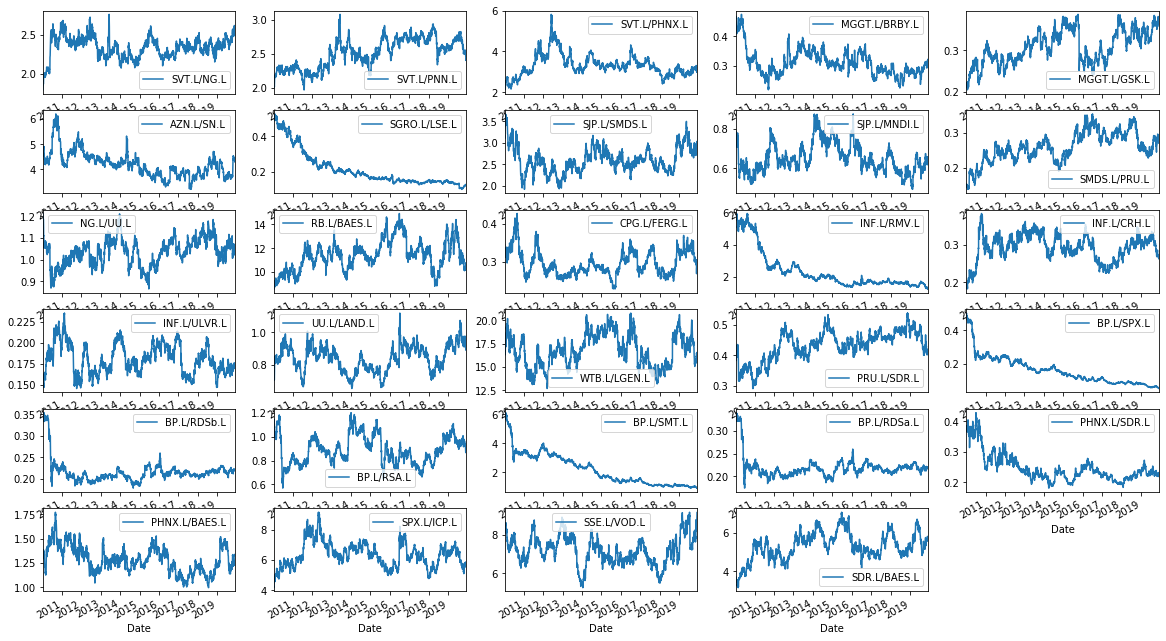

In [20]:
fig = plt.figure(figsize=(20,20))
for i,col in enumerate(pairlist.columns):
    ax=plt.subplot(10,5,i+1) 
    pairlist[[col]].plot(ax=ax)
    
plt.show()

<a id='Conclusion'></a>
### Conclusion

In this article - we have covered the basic idea  behind pair-trading - which is a time-honoured market-neutral type of statistical arbitrage (stat-arb) strategy. We explained some of the salient points using a single pair as an example. Given the 2-fold weakness in this manual strategy - we needed to know what an appropriate pair might be - and the lack of a robust statistical selection process - we then embarked on a journey to industrialise our search process using brute force calculations of all relevant combinations of index constituents - in our case the FTSE 100.

Along the way we implemented iterative API calls to build a larger dataframe than a single call would allow for. We also implemented various statistical testing routines to try to add some robustness to our search and then used some simple filters to narrow down our universe to the most promising candidates. Along the way we met a new friend - Swifter - which offers great potential speedups via vectorisation or Dask parallelisation with basically no additional knowledge, code or effort. To be honest I already thought multiprocessing/multiprocess was fairly concise and straightforward - but Swifter really blew me away. I **strongly** recommend adding it to your toolkit for pandas intensive calculation workflows. 

Finally - we graphed the filtered pair ratios *en-masse* so we could see the rough shapes of the ratios using the easy to use and efficient FacetGrid charting. 

From the charts above we can see some very promising candidates which appear to have stable mean-reverting shapes. Annoyingly - also present are a number of shapes which although seemingly satisfying our statistical criterial, do not appear to be of an appropriate character. We would need to investigate this further which is beyond the scope of this article - suffice to say there are statistical exceptions to our basic rule filters which we may need to take account for or modify. 

From here we could select appropriate pairs and then go to the next level of selecting appropriate +/- standard-deviation thresholds - by eye - but better still automating it all via algorithm. Again that is beyond the scope of this article. 

For my eye - the most promising pairs from the list are INF.L/ULVR.L, UU.L/Land.L, WTB.L/LGEN.L, BP.L/RSA.L, PHNX.L/BAES.L, SPX.L/ICP.L. Of course - these are not in any way to be construed as recommendations or solicitations - just candidates worthy of further research and testing - again beyond the scope of this article.

I hope to have introduced the basic concepts of this type of strategy and provided you with a practical codebase to investigate further.

<a id='Resources'></a>
**Further Resources for Eikon Data API**

* [Overview](https://developers.refinitiv.com/eikon-data-apis) 
* [Quick Start ](https://developers.refinitiv.com/eikon-data-apis/quick-start)
* [Documentation](https://developers.refinitiv.com/eikon-data-apis/docs)
* [Downloads](https://developers.refinitiv.com/eikon-data-apis/downloads)
* [Tutorials](https://developers.refinitiv.com/eikon-data-apis/learning)
* [Q&A Forums](https://developers.refinitiv.com/eikon-data-apis/qa)

For Content Navigation in Eikon - please use the Data Item Browser Application: Type 'DIB' into Eikon Search Bar.


<img src="https://developers.refinitiv.com/sites/all/themes/custom/trpdc_schwinn/imgs/logo/refinitiv_header_logo.svg" width="50%" align="right" style="vertical-align: top; padding-top: 23px;">